# Setup

In [1]:
import pandapower.networks as pnet
import pandas as pd
import numpy as np
import scipy as sp
import cvxpy as cp
import seaborn as sns
import mlflow

from scipy import sparse

In [2]:
%load_ext autoreload
%autoreload 2

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import sys
sys.path.insert(1, '..')

from src.models.matrix_operations import make_real_vector, vectorize_matrix
from src.simulation.noise import add_polar_noise_to_measurement
from src.models.regression import ComplexRegression, ComplexLasso
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.simulation.load_profile import generate_gaussian_load
from src.simulation.network import add_load_power_control, make_y_bus
from src.simulation.simulation import run_simulation, get_current_and_voltage
from src.identification.error_metrics import error_metrics, fro_error
from src.models.noise_transformation import average_true_noise_covariance

# Network simulation

In [4]:
mlflow.set_experiment('Full network with cartesian noise')

In [5]:
net = pnet.create_kerber_landnetz_freileitung_2()
steps = 400
load_cv = 0.2
v_noise_sds = np.array([0.02, 0.08, 0.01, 0.07, 0.05, 0.03, 0.04, 0.02, 0.06]) * 1e-3
i_noise_sds = np.array([0.03, 0.04, 0.01, 0.02, 0.04, 0.07, 0.02, 0.04, 0.06]) * 1e-4

In [6]:
np.random.seed(11)
load_p, load_q = generate_gaussian_load(net.load.p_mw, net.load.q_mvar, load_cv, steps)
controlled_net = add_load_power_control(net, load_p, load_q)
sim_result = run_simulation(controlled_net, verbose=False)
y_bus = make_y_bus(controlled_net)
voltage, current = get_current_and_voltage(sim_result, y_bus)
controlled_net.bus

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


,name,vn_kv,type,zone,in_service
0,Trafostation_OS,10.0,b,None,True
1,main_busbar,0.4,b,None,True
2,bus_1_1,0.4,b,None,True
3,bus_1_2,0.4,b,None,True
4,bus_1_3,0.4,b,None,True
5,bus_1_4,0.4,b,None,True
6,bus_1_5,0.4,b,None,True
7,bus_1_6,0.4,b,None,True
8,bus_2_1,0.4,b,None,True
9,bus_2_2,0.4,b,None,True


In [7]:
voltage = voltage[:, 1:]
y_bus = y_bus[1:, 1:]
current = np.array(voltage @ y_bus)
nodes = voltage.shape[1]

noisy_voltage = voltage.copy() + np.random.normal(0, v_noise_sds, (steps, nodes)) + 1j*np.random.normal(0, v_noise_sds, (steps, nodes))
noisy_current = current.copy() + np.random.normal(0, i_noise_sds, (steps, nodes)) + 1j*np.random.normal(0, i_noise_sds, (steps, nodes))

voltage_error, current_error = noisy_voltage - voltage, noisy_current - current

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
np.linalg.svd(voltage, compute_uv=False)

array([5.89221591e+01, 4.25232562e-02, 1.35369650e-02, 5.73441653e-03,
       2.75443540e-03, 2.25199217e-03, 1.55263364e-03, 1.16434339e-03,
       9.41492168e-04])

In [9]:
np.mean(np.abs(current), 0)

array([2.49996625, 0.00810926, 0.00811186, 0.00817258, 0.00823941,
       0.00830128, 0.00824192, 0.00803008, 0.0081679 ])

In [10]:
mlflow_params = {
    'nodes': nodes,
    'steps': steps, 
    'load_cv': load_cv, 
    'v_noise_sds': v_noise_sds, 
    'i_noise_sds': i_noise_sds
}

# OLS Identification

In [11]:
with mlflow.start_run(run_name='OLS'):
    ols = ComplexRegression()
    ols.fit(noisy_voltage, noisy_current)
    y_ols = ols.fitted_admittance_matrix
    ols_metrics = error_metrics(y_bus, y_ols)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(ols_metrics.__dict__)
ols_metrics

ErrorMetrics(fro_error=32.71001813242517, max_error=12.082856959639567, rrms_error=0.5683413468374057, map_error=0.4728404248718394)

# Lasso Identification

In [12]:
with mlflow.start_run(run_name='Lasso'):
    lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-12, -1, 40), solver=cp.GUROBI)
    lasso.fit(noisy_voltage, noisy_current)
    y_lasso = lasso.fitted_admittance_matrix
    lasso_metrics = error_metrics(y_bus, y_lasso)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(lasso_metrics.__dict__)
best_lambda = lasso.best_trial.hyperparameters['lambda']
lasso_metrics

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,


Using license file /Users/jbrouill/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-17


ErrorMetrics(fro_error=32.71001764840301, max_error=12.082856927453864, rrms_error=0.5683413384274498, map_error=0.472840411602191)

In [13]:
best_lambda

1.8047217668271666e-10

# TLS Identification

In [14]:
with mlflow.start_run(run_name='TLS'):
    tls = TotalLeastSquares()
    tls.fit(noisy_voltage, noisy_current)
    y_tls = tls.fitted_admittance_matrix
    tls_metrics = error_metrics(y_bus, y_tls)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(tls_metrics.__dict__)
tls_metrics

[[ 0.0296478 +0.06186058j  0.00947051+0.02325311j  0.00848535+0.05619098j
   0.00326295-0.01837686j -0.03297536-0.00512281j -0.11461229-0.07034184j
   0.02112096-0.00369264j -0.05299115-0.09220264j -0.00541987-0.25198695j]
 [ 0.07476975+0.07429469j  0.0371842 +0.02861018j -0.01433277+0.03344574j
  -0.00793605-0.03109856j -0.01511965+0.00214285j -0.06639273-0.03263963j
   0.02247668+0.00113361j -0.00155611-0.07481696j -0.05149464-0.27843354j]
 [ 0.0367499 +0.02622073j  0.04715211+0.039445j   -0.0336651 +0.01040055j
  -0.00709985-0.04227173j -0.00228763+0.01045498j -0.02191911+0.00577964j
   0.02140094+0.00385276j  0.04918486-0.05766749j -0.09622454-0.30466113j]
 [ 0.00414863-0.01174173j  0.06709157+0.05162357j -0.05089949-0.01367592j
  -0.01815705-0.06345321j  0.02630557+0.01524731j  0.04665048+0.06389159j
   0.02686322+0.01286091j  0.02891103-0.0779135j  -0.10371542-0.31044786j]
 [-0.01326618-0.01519669j  0.01028311+0.01709335j -0.05996907-0.03492801j
  -0.02150669-0.07526497j  0.04692

ErrorMetrics(fro_error=5.805573730824343, max_error=1.7795850845522634, rrms_error=0.10087269227373967, map_error=0.047581177259973705)

# L1 Regularized TLS

In [15]:
with mlflow.start_run(run_name='S-TLS no covariance'):
    max_iterations = 50
    abs_tol = 10e-12
    rel_tol = 10e-12
    solver = cp.GUROBI
    use_cov_matrix = False
    
    sparse_tls = SparseTotalLeastSquare(lambda_value=best_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls.fit(noisy_voltage, noisy_current)
    
    y_sparse_tls = sparse_tls.fitted_admittance_matrix
    sparse_tls_metrics = error_metrics(y_bus, y_sparse_tls)
    
    sparse_tls_errors = pd.Series([fro_error(y_bus, i.fitted_parameters) for i in sparse_tls.iterations])
    sparse_tls_targets = pd.Series([i.target_function for i in sparse_tls.iterations])
    
    mlflow.log_param('lambda', best_lambda)
    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_metrics.__dict__)

    for i in range(len(sparse_tls_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_targets[i], step=i)

100%|██████████| 50/50 [01:51<00:00,  2.24s/it]


<AxesSubplot:>

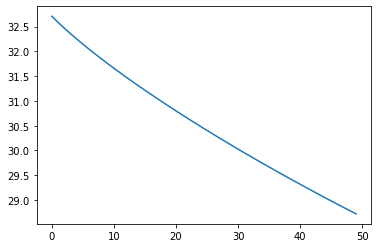

In [16]:
sparse_tls_errors.plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

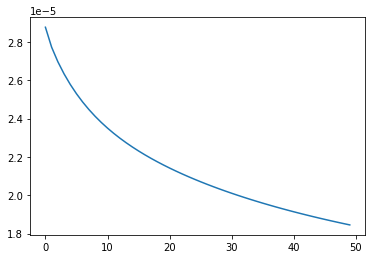

In [17]:
sparse_tls_targets.plot()

In [18]:
def create_inv_cov(sds, samples):
    variances = np.array(sds)**2
    variance_diag = np.concatenate([np.repeat(variances, samples), np.repeat(variances, samples)])
    cov_matrix = sp.sparse.diags(variance_diag, format='csc')
    inv_cov_matrix = sp.sparse.linalg.inv(cov_matrix)
    return inv_cov_matrix

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
with mlflow.start_run(run_name='S-TLS with covariance'):
    max_iterations = 50
    abs_tol = 10e-12
    rel_tol = 10e-12
    solver = cp.GUROBI
    use_cov_matrix = True
    
    inv_sigma_current = create_inv_cov(i_noise_sds, steps)
    inv_sigma_voltage = create_inv_cov(v_noise_sds, steps)
    
    sparse_tls_cov = SparseTotalLeastSquare(lambda_value=best_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls_cov.fit(noisy_voltage, noisy_current, inv_sigma_voltage, inv_sigma_current)
    
    y_sparse_tls_cov = sparse_tls_cov.fitted_admittance_matrix
    sparse_tls_cov_metrics = error_metrics(y_bus, y_sparse_tls_cov)
    
    sparse_tls_cov_errors = pd.Series([fro_error(y_bus, i.fitted_parameters) for i in sparse_tls_cov.iterations])
    sparse_tls_cov_targets = pd.Series([i.target_function for i in sparse_tls_cov.iterations])
    
    mlflow.log_param('lambda', best_lambda)
    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_cov_metrics.__dict__)

    for i in range(len(sparse_tls_cov_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_cov_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_cov_targets[i], step=i)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


<AxesSubplot:>

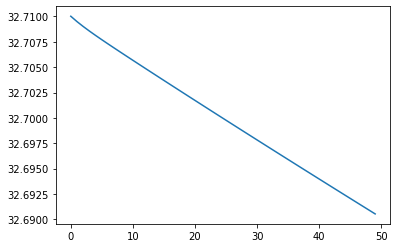

In [20]:
sparse_tls_cov_errors.plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

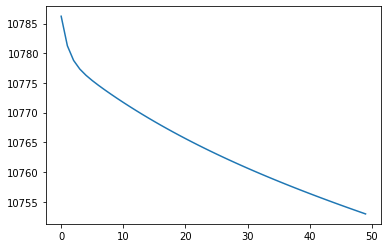

In [21]:
sparse_tls_cov_targets.plot()

# Result analysis

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


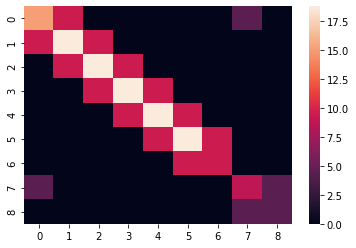

In [22]:
sns.heatmap(np.abs(y_bus));

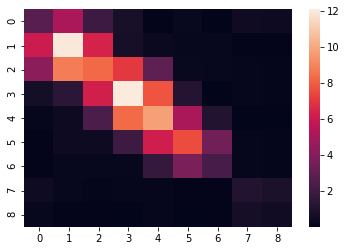

In [23]:
sns.heatmap(np.abs(y_bus - y_ols));

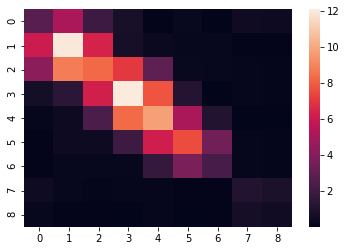

In [24]:
sns.heatmap(np.abs(y_bus - y_lasso));

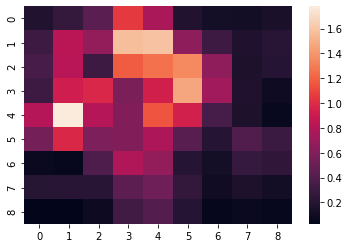

In [25]:
sns.heatmap(np.abs(y_bus - y_tls));

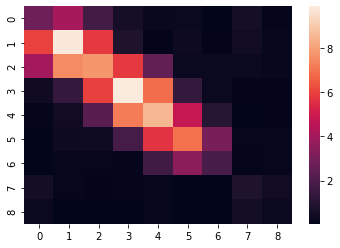

In [26]:
sns.heatmap(np.abs(y_bus - y_sparse_tls));

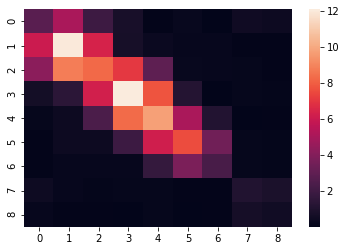

In [27]:
sns.heatmap(np.abs(y_bus - y_sparse_tls_cov));